# Task1 County Crimes_Analyzing data with sparksql

In [230]:
!pip install pyspark==3.2

In [231]:
#starting spark session and configuration
#importing to modify the codes
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#creating an instance of SQLContext
sqlContext = SQLContext(spark)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [232]:
# Import libraries to perform arithematic calculations, visualisation and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Analyzing Crimes in all Counties (Merseyside, West Midlands, West Yorkshire & Nottingham)

In [233]:
countycrimes = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/county-datasets/*/*street.csv")

In [234]:
countycrimes.count()

2028017

In [235]:
#Renaming the columns for consistency which are to be analyzed 
countycrimes = countycrimes.withColumnRenamed('Crime type', 'Crime_type')
countycrimes = countycrimes.withColumnRenamed('Last outcome category', 'Last_outcome_category')
countycrimes.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [236]:
# Create new data frame with Month and Counts per Month
countycrimes1 = countycrimes.select(countycrimes.Month)\
.groupby(countycrimes.Month).count()

In [237]:
#monthly crimes in 2022 and 2023
countycrimes1.orderBy(desc("Count")).orderBy('Month').show(24)

+-------+-----+
|  Month|count|
+-------+-----+
|2022-01|81412|
|2022-02|79480|
|2022-03|90228|
|2022-04|87739|
|2022-05|94807|
|2022-06|88030|
|2022-07|91070|
|2022-08|93184|
|2022-09|84000|
|2022-10|87572|
|2022-11|84955|
|2022-12|76702|
|2023-01|81440|
|2023-02|81596|
|2023-03|88259|
|2023-04|86385|
|2023-05|89587|
|2023-06|88057|
|2023-07|85822|
|2023-08|80335|
|2023-09|79691|
|2023-10|80874|
|2023-11|75848|
|2023-12|70944|
+-------+-----+



In [238]:
#register temp table to execute sql queries
countycrimes1.registerTempTable("countycrimes1_table")
countycrimes_monthly = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
avg(count) as Average from countycrimes1_table group by substring(Month, 6, 2)")
countycrimes_monthly.orderBy(desc("Average")).show()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


+-----+-------+
|Month|Average|
+-----+-------+
|   05|92197.0|
|   03|89243.5|
|   07|88446.0|
|   06|88043.5|
|   04|87062.0|
|   08|86759.5|
|   10|84223.0|
|   09|81845.5|
|   01|81426.0|
|   02|80538.0|
|   11|80401.5|
|   12|73823.0|
+-----+-------+



In [239]:
countycrimes_monthlynew = countycrimes_monthly.orderBy('Month')
countycrimes_monthlynew.registerTempTable("countycrimes_monthlynew_table")
#Retrieve average data of two years by months
sqlContext.sql("select * from countycrimes_monthlynew_table").show(24)

+-----+-------+
|Month|Average|
+-----+-------+
|   01|81426.0|
|   02|80538.0|
|   03|89243.5|
|   04|87062.0|
|   05|92197.0|
|   06|88043.5|
|   07|88446.0|
|   08|86759.5|
|   09|81845.5|
|   10|84223.0|
|   11|80401.5|
|   12|73823.0|
+-----+-------+



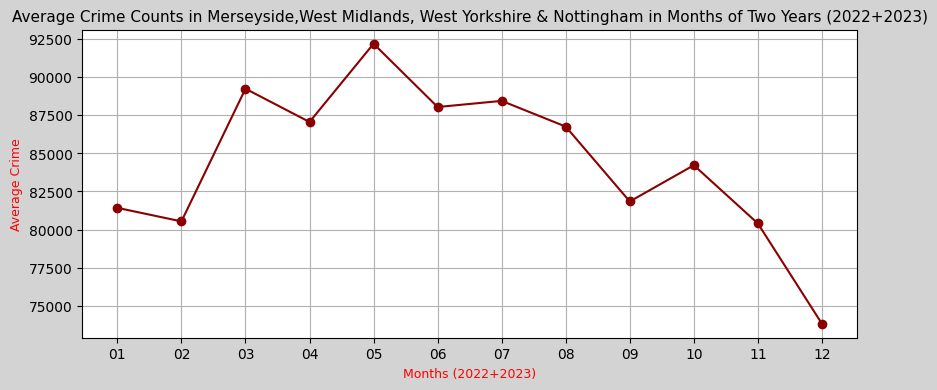

In [240]:
#converting datafrmae into rdd, mapping and setting arrays for visualization
monthArray = sqlContext.sql("select Month from countycrimes_monthlynew_table")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from countycrimes_monthlynew_table")\
.rdd.map(lambda f:f[0]).collect()

m = monthArray
a = monthAvgArray
plt.figure (figsize = (10,4), facecolor='lightgrey')
plt.plot(m, a, 'o-', color = 'darkred')
plt.title('Average Crime Counts in Merseyside,West Midlands, West Yorkshire & Nottingham in Months of Two Years (2022+2023)', 
          color='black', fontsize=11, fontstyle='normal', fontname='calibri')
plt.xlabel('Months (2022+2023)', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("countycrimes_monthly.png")
plt.show()

In [241]:
#retrieving action outcomes of all four counties
countycrimes.groupby ("Crime_type").count().orderBy (desc("count")).show(truncate=False)

+----------------------------+------+
|Crime_type                  |count |
+----------------------------+------+
|Violence and sexual offences|811981|
|Public order                |202872|
|Anti-social behaviour       |170728|
|Criminal damage and arson   |164839|
|Vehicle crime               |133859|
|Other theft                 |132972|
|Shoplifting                 |122100|
|Burglary                    |92744 |
|Drugs                       |65241 |
|Other crime                 |41671 |
|Robbery                     |27923 |
|Possession of weapons       |24995 |
|Theft from the person       |21485 |
|Bicycle theft               |14607 |
+----------------------------+------+



In [242]:
countycrimetypes = countycrimes.groupby ("Crime_type").count().orderBy (desc("count")).toPandas()

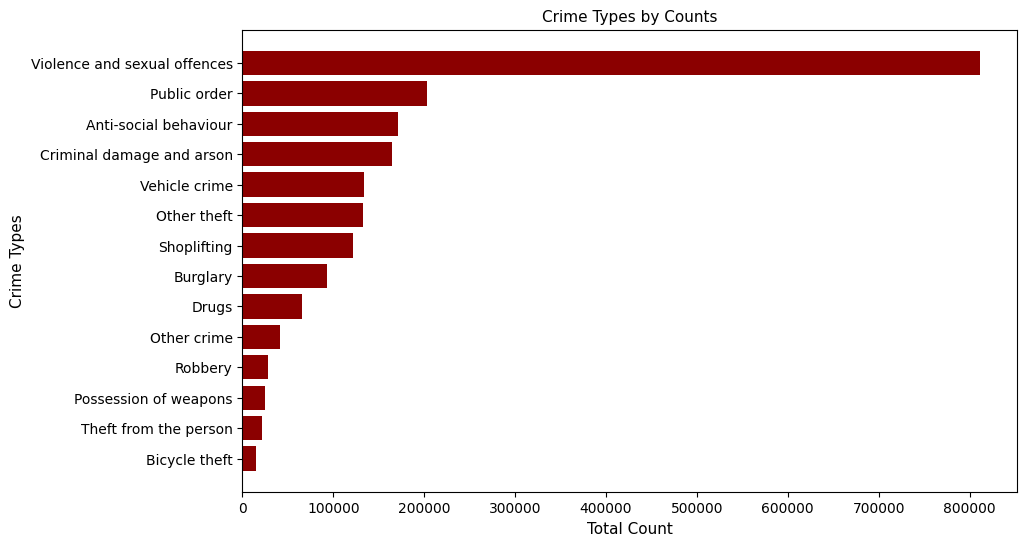

In [243]:
#Visualize the graph to see the types of crimes and the counts
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
plt.figure(figsize=(10, 6))
plt.barh(countycrimetypes['Crime_type'], countycrimetypes['count'], color='darkred')
plt.xlabel('Total Count', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Crime Types', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Crime Types by Counts', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

In [244]:
#retrieving action outcomes of all four counties
countycrimes.groupby ("Last_outcome_category").count().orderBy (desc("count")).show(truncate=False)

+---------------------------------------------------+------+
|Last_outcome_category                              |count |
+---------------------------------------------------+------+
|Unable to prosecute suspect                        |849952|
|Investigation complete; no suspect identified      |714725|
|null                                               |170728|
|Court result unavailable                           |112641|
|Status update unavailable                          |62594 |
|Local resolution                                   |40647 |
|Action to be taken by another organisation         |25322 |
|Further investigation is not in the public interest|13293 |
|Offender given a caution                           |12601 |
|Further action is not in the public interest       |10354 |
|Awaiting court outcome                             |7875  |
|Formal action is not in the public interest        |5088  |
|Offender given a drugs possession warning          |919   |
|Suspect charged as part

In [245]:
#counting nulls and removing them for visualization
action_outcome = countycrimes.filter(countycrimes.Last_outcome_category.isNull()).count()
print(action_outcome)
action_outcome = countycrimes.dropna(subset=['Last_outcome_category'])  

170728


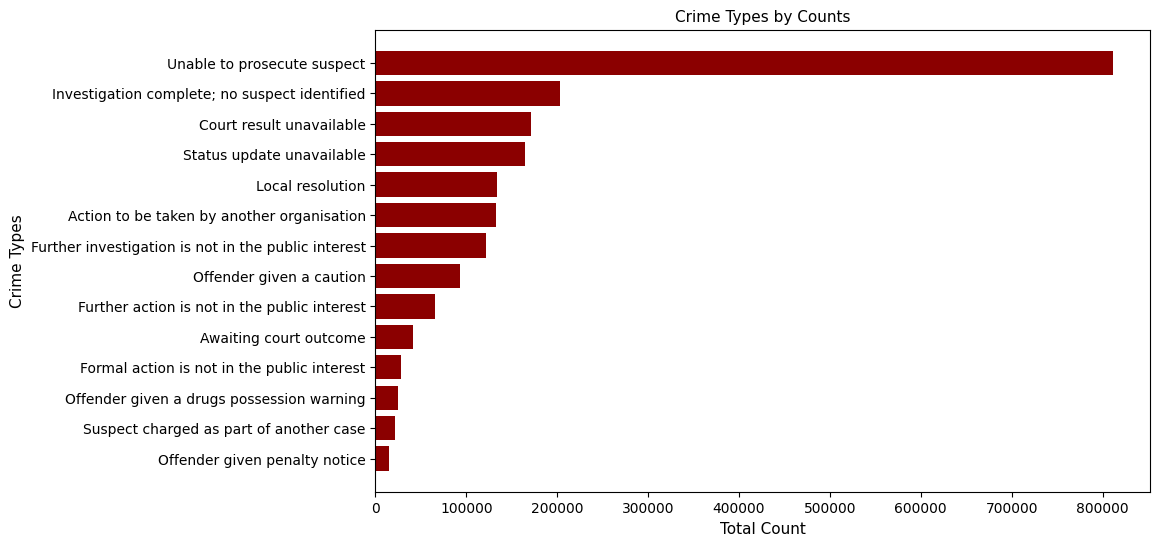

In [246]:
#convert spark data frame into pandas data frame
outcome = action_outcome.groupby ("Last_outcome_category").count().orderBy (desc("count")).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(outcome['Last_outcome_category'], countycrimetypes['count'], color='darkred')
plt.xlabel('Total Count', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Crime Types', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Crime Types by Counts', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

## Merseyside

In [247]:
#create a dataFrame directly from Merseyside county crime csv file 
#https://data.police.uk/data/
Merseysidecrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/county-datasets/Merseyside_data/*street.csv") 

In [248]:
#Check data types of each column
Merseysidecrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [249]:
#Renaming the columns for consistency
Merseysidecrime = Merseysidecrime.withColumnRenamed('Crime ID', 'Crime_ID')
Merseysidecrime = Merseysidecrime.withColumnRenamed('Reported by', 'Reported_by')
Merseysidecrime = Merseysidecrime.withColumnRenamed('Falls within', 'Falls_within')
Merseysidecrime = Merseysidecrime.withColumnRenamed('LSOA code', 'LSOA_code')
Merseysidecrime = Merseysidecrime.withColumnRenamed('LSOA name', 'LSOA_name')
Merseysidecrime = Merseysidecrime.withColumnRenamed('Crime type', 'Crime_type')
Merseysidecrime = Merseysidecrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [250]:
#Re-check column names
Merseysidecrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [251]:
#Count total rows/crimes
Merseysidecrime.count()

353676

In [252]:
#Checking numbers of null values in the column Context
null_context_mer = Merseysidecrime.filter(Merseysidecrime.Context.isNull())
null_context_mer.count()

353676

In [253]:
#Drop Context column and re_check
Merseysidecrime = Merseysidecrime.drop ('Context')
Merseysidecrime

DataFrame[Crime_ID: string, Month: string, Reported_by: string, Falls_within: string, Longitude: double, Latitude: double, Location: string, LSOA_code: string, LSOA_name: string, Crime_type: string, Last_outcome_category: string]

In [254]:
#Check null values in IDs
#https://sparkbyexamples.com/pyspark/pyspark-filter-rows-with-null-values/

nullid_Merseyside = Merseysidecrime.filter(Merseysidecrime.Crime_ID.isNull())
nullid_Merseyside.count()

31878

In [255]:
#Check null value rows for other columns
nulls_Merseyside = Merseysidecrime.groupBy("Crime_ID","Crime_type","Last_outcome_category").count().filter(col("count") > 1)
nulls_Merseyside.show()

+--------+--------------------+---------------------+-----+
|Crime_ID|          Crime_type|Last_outcome_category|count|
+--------+--------------------+---------------------+-----+
|    null|Anti-social behav...|                 null|31878|
+--------+--------------------+---------------------+-----+



In [256]:
#Retrieve counts for each month ordered in descending order
Merseysidecrime.groupby("Month").count().orderBy(desc("count")).take(24)

[Row(Month='2022-05', count=17200),
 Row(Month='2022-08', count=16512),
 Row(Month='2022-03', count=16476),
 Row(Month='2022-10', count=15918),
 Row(Month='2022-06', count=15900),
 Row(Month='2022-07', count=15899),
 Row(Month='2023-05', count=15591),
 Row(Month='2022-04', count=15571),
 Row(Month='2022-11', count=15358),
 Row(Month='2022-09', count=15260),
 Row(Month='2022-01', count=15029),
 Row(Month='2023-06', count=15025),
 Row(Month='2023-03', count=14858),
 Row(Month='2023-04', count=14518),
 Row(Month='2022-02', count=14164),
 Row(Month='2023-01', count=14147),
 Row(Month='2023-02', count=14090),
 Row(Month='2023-07', count=13825),
 Row(Month='2023-08', count=13741),
 Row(Month='2023-09', count=13566),
 Row(Month='2023-10', count=13449),
 Row(Month='2022-12', count=13186),
 Row(Month='2023-11', count=12525),
 Row(Month='2023-12', count=11868)]

In [257]:
#Retrieve counts for each year ordered in descending order
Merseysidecrime.select(substring(Merseysidecrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+------+
|Year| count|
+----+------+
|2022|186473|
|2023|167203|
+----+------+



In [258]:
#Retrieve monthly counts of crime
Merseysidecrime.\
select(substring(Merseysidecrime.Month, 1,7)\
                                                          \
       .alias('Month'), Merseysidecrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).collect()

[Row(Month='2022-05', count=17200),
 Row(Month='2022-08', count=16512),
 Row(Month='2022-03', count=16476),
 Row(Month='2022-10', count=15918),
 Row(Month='2022-06', count=15900),
 Row(Month='2022-07', count=15899),
 Row(Month='2023-05', count=15591),
 Row(Month='2022-04', count=15571),
 Row(Month='2022-11', count=15358),
 Row(Month='2022-09', count=15260),
 Row(Month='2022-01', count=15029),
 Row(Month='2023-06', count=15025),
 Row(Month='2023-03', count=14858),
 Row(Month='2023-04', count=14518),
 Row(Month='2022-02', count=14164),
 Row(Month='2023-01', count=14147),
 Row(Month='2023-02', count=14090),
 Row(Month='2023-07', count=13825),
 Row(Month='2023-08', count=13741),
 Row(Month='2023-09', count=13566),
 Row(Month='2023-10', count=13449),
 Row(Month='2022-12', count=13186),
 Row(Month='2023-11', count=12525),
 Row(Month='2023-12', count=11868)]

In [259]:
#Register temporary table to perform sql which is stored in cache memory
Merseysidecrime.registerTempTable("Merseysidecrime_table")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [260]:
# Create new data frame with Month and Counts per Month
Merseysidecrime1 = Merseysidecrime.select(Merseysidecrime.Month)\
.groupby(Merseysidecrime.Month).count()

In [261]:
#Register temporary table
Merseysidecrime1.registerTempTable("Merseysidecrime1_table")

In [262]:
# Create new dataframe with month and average crime count
Merseyside_monthly_crime = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
avg(count) as Average from Merseysidecrime1_table group by substring(Month, 6, 2)")
Merseyside_monthly_crime.orderBy(desc("Average")).show()

+-----+-------+
|Month|Average|
+-----+-------+
|   05|16395.5|
|   03|15667.0|
|   06|15462.5|
|   08|15126.5|
|   04|15044.5|
|   07|14862.0|
|   10|14683.5|
|   01|14588.0|
|   09|14413.0|
|   02|14127.0|
|   11|13941.5|
|   12|12527.0|
+-----+-------+



In [263]:
#Retrieve data
Merseyside_monthly_crime_new = Merseyside_monthly_crime.orderBy('Month')

In [264]:
# Register temp table for monthly crime
# DataFrame as a temp table and show the contents
Merseyside_monthly_crime_new.registerTempTable("Merseyside_monthly_crime_tb")
#Retrieve average data of two years by months
sqlContext.sql("select * from Merseyside_monthly_crime_tb").show(24)

+-----+-------+
|Month|Average|
+-----+-------+
|   01|14588.0|
|   02|14127.0|
|   03|15667.0|
|   04|15044.5|
|   05|16395.5|
|   06|15462.5|
|   07|14862.0|
|   08|15126.5|
|   09|14413.0|
|   10|14683.5|
|   11|13941.5|
|   12|12527.0|
+-----+-------+



In [265]:
#Prepare varibles for visualisation
#Convert dataframe into RDD
monthArray = sqlContext.sql("select Month from Merseyside_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from Merseyside_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

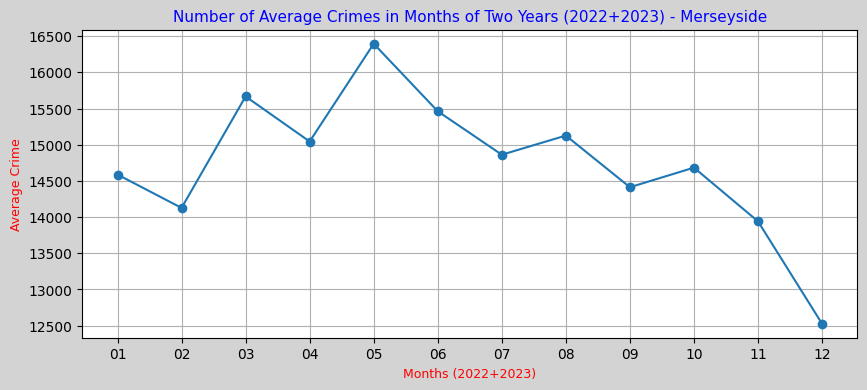

In [266]:
#Plot the monthly visualisation set title, x,y labels, format font
import matplotlib.pyplot as plt
import numpy as np

m = monthArray
a = monthAvgArray
plt.figure (figsize = (10,4), facecolor='lightgrey')
plt.plot(m, a, 'o-')
plt.title('Number of Average Crimes in Months of Two Years (2022+2023) - Merseyside', 
          color='blue', fontsize=11, fontstyle='normal', fontname='calibri')
plt.xlabel('Months (2022+2023)', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("Merseyside_monthly_crime.png")
plt.show()

In [267]:
#Create dataframe to retrieve yearly total and average crimes
Merseyside_yearly_crime = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
Merseysidecrime1_table group by substring(Month, 0, 4)")

In [268]:
#Register temporary table
Merseyside_yearly_crime.registerTempTable("Merseyside_yearly_crime_tb")
sqlContext.sql("select * from Merseyside_yearly_crime_tb").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|186473|15539.416666666666|
|2023|167203|13933.583333333334|
+----+------+------------------+



In [269]:
#Prepare variables for visualisation
#Converting dataframe into RDD
totalArray = sqlContext.sql("select Total from Merseyside_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Merseyside_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from Merseyside_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

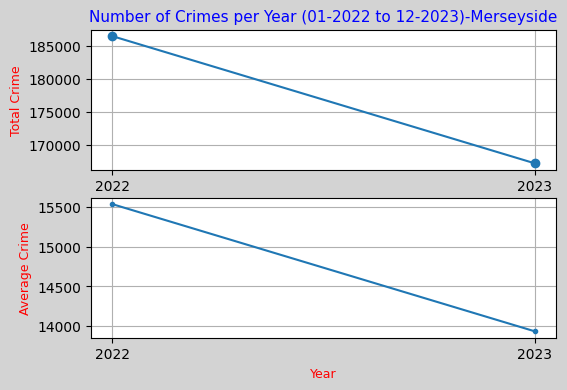

In [270]:
#Plot the yearly visualisation set title, x,y labels, format font
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray
plt.figure (figsize = (6,4), facecolor='lightgrey')

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Number of Crimes per Year (01-2022 to 12-2023)-Merseyside', color = 'blue', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.ylabel('Total Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("Merseyside_yearly_crime.png")
plt.show()

In [271]:
sqlContext.sql("select Month, substring(Month, 0, 4)\
as Year, count(*) as Count from Merseysidecrime_table group by Month  order by Month asc").show(24)

+-------+----+-----+
|  Month|Year|Count|
+-------+----+-----+
|2022-01|2022|15029|
|2022-02|2022|14164|
|2022-03|2022|16476|
|2022-04|2022|15571|
|2022-05|2022|17200|
|2022-06|2022|15900|
|2022-07|2022|15899|
|2022-08|2022|16512|
|2022-09|2022|15260|
|2022-10|2022|15918|
|2022-11|2022|15358|
|2022-12|2022|13186|
|2023-01|2023|14147|
|2023-02|2023|14090|
|2023-03|2023|14858|
|2023-04|2023|14518|
|2023-05|2023|15591|
|2023-06|2023|15025|
|2023-07|2023|13825|
|2023-08|2023|13741|
|2023-09|2023|13566|
|2023-10|2023|13449|
|2023-11|2023|12525|
|2023-12|2023|11868|
+-------+----+-----+



In [272]:
#Register temporary table for crime type
Merseysidecrime.registerTempTable("Merseyside_crimetype_table")

In [273]:
#Retrieving crime types 
Merseyside_crime_types = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year,\
count(*) as Count from Merseyside_crimetype_table group by Month, Crime_type")

In [274]:
Merseyside_crime_types.show(25)

+--------------------+-------+----+-----+
|          Crime_type|  Month|Year|Count|
+--------------------+-------+----+-----+
|Anti-social behav...|2022-03|2022| 1414|
|         Shoplifting|2022-11|2022|  558|
|       Bicycle theft|2023-05|2023|  116|
|Possession of wea...|2023-06|2023|  117|
|Theft from the pe...|2023-06|2023|  136|
|Possession of wea...|2022-05|2022|  105|
|               Drugs|2022-10|2022|  959|
|Criminal damage a...|2022-07|2022| 1290|
|Possession of wea...|2022-10|2022|  101|
|Criminal damage a...|2022-08|2022| 1326|
|            Burglary|2023-05|2023|  431|
|         Shoplifting|2023-05|2023|  727|
|       Vehicle crime|2023-06|2023|  497|
|            Burglary|2022-07|2022|  407|
|Theft from the pe...|2022-05|2022|  241|
|Violence and sexu...|2022-04|2022| 6135|
|         Other crime|2022-08|2022|  333|
|        Public order|2022-07|2022| 2458|
|       Vehicle crime|2022-01|2022|  616|
|         Other theft|2022-06|2022|  817|
|       Vehicle crime|2022-06|2022

In [275]:
#Retreiving crime types in descending order
Merseysidecrime.groupby ("Crime_type").count().orderBy (desc("count")).show()

+--------------------+------+
|          Crime_type| count|
+--------------------+------+
|Violence and sexu...|140503|
|        Public order| 47671|
|Anti-social behav...| 31878|
|Criminal damage a...| 29738|
|               Drugs| 23652|
|         Other theft| 20102|
|         Shoplifting| 15459|
|       Vehicle crime| 14210|
|            Burglary| 11562|
|         Other crime|  6605|
|Theft from the pe...|  4307|
|       Bicycle theft|  2905|
|Possession of wea...|  2616|
|             Robbery|  2468|
+--------------------+------+



In [276]:
#convert the data frame into pandas
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html
crimetype_M = Merseysidecrime.groupby ("Crime_type").count().orderBy (desc("count")).toPandas()

In [277]:
print(crimetype_M.columns)

Index(['Crime_type', 'count'], dtype='object')


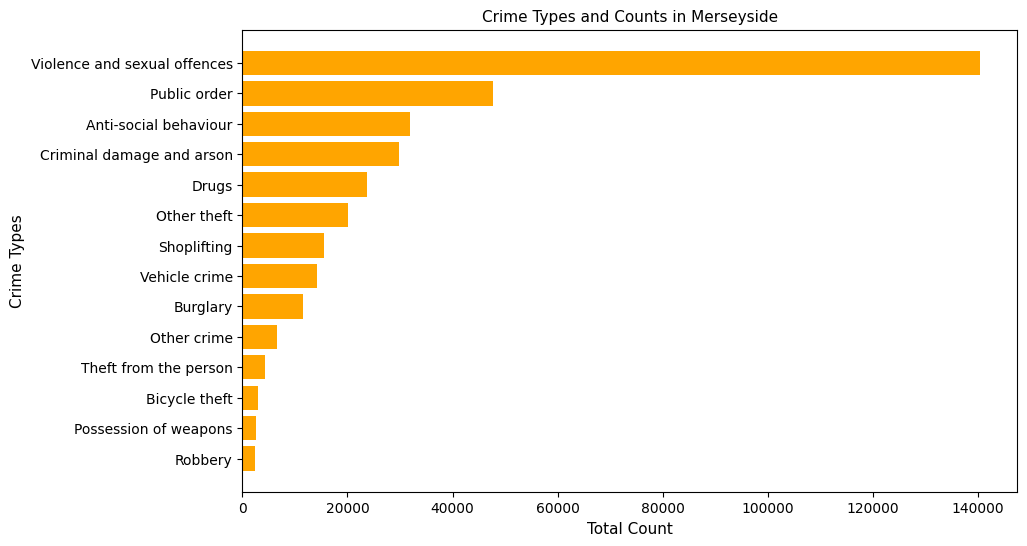

In [278]:
#Visualize the graph to see the types of crimes and the counts
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
plt.figure(figsize=(10, 6))
plt.barh(crimetype_M['Crime_type'], crimetype_M['count'], color='Orange')
plt.xlabel('Total Count', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Crime Types', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Crime Types and Counts in Merseyside', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

In [279]:
#Retreiving outcomes in descending order
Merseysidecrime.groupby ("Last_outcome_category").count().orderBy (desc("count")).show(truncate=False)

+---------------------------------------------------+------+
|Last_outcome_category                              |count |
+---------------------------------------------------+------+
|Unable to prosecute suspect                        |146788|
|Investigation complete; no suspect identified      |111653|
|null                                               |31878 |
|Court result unavailable                           |26749 |
|Local resolution                                   |12379 |
|Further investigation is not in the public interest|5632  |
|Status update unavailable                          |5465  |
|Further action is not in the public interest       |4809  |
|Action to be taken by another organisation         |3794  |
|Awaiting court outcome                             |2155  |
|Offender given a caution                           |1436  |
|Formal action is not in the public interest        |804   |
|Offender given a drugs possession warning          |65    |
|Suspect charged as part

In [280]:
#Retrieving geographic of crimes in month and year
Merseyside_CrimeTypesGeo = sqlContext.sql("select Crime_type, Month,\
substring(Month, 0, 4) as Year, Location, LSOA_name,\
count(*) as Count from Merseyside_crimetype_table group by Month, \
Crime_type, Location, LSOA_name order by Count desc")

In [281]:
from pyspark.sql import functions as F

# Extract the city name from 'LSOA_name' by splitting the string at the space and taking the first part
merge_m = Merseysidecrime.withColumn('City', F.split('LSOA_name', ' ').getItem(0))

# Group by the extracted city and count the number of crimes for each city
topcity_m = merge_m.groupby('City').agg(F.count('Crime_ID').alias('Total_Crimes'))

# Sort by Total_Crimes in descending order
topcity_m = topcity_m.orderBy(F.desc('Total_Crimes')).limit(5).toPandas()
topcity_m

,City,Total_Crimes
0,Liverpool,141898
1,Wirral,57016
2,Sefton,50879
3,St.,40314
4,Knowsley,31553


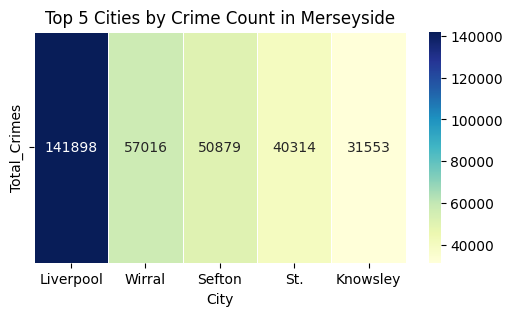

In [282]:
#setting city as index, transposing=swapping columns and rows
heatmap_city = topcity_m.set_index("City")["Total_Crimes"].to_frame().transpose()
#Plot the heatmap using Seaborn
plt.figure(figsize=(6, 3))  # Adjusted figure size for better clarity
sns.heatmap(heatmap_city, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5)

plt.title('Top 5 Cities by Crime Count in Merseyside', color='Black', fontsize=12, fontstyle='normal', fontname='calibri(body)')
plt.show()

In [283]:
#Retrieving the top 5 areas by total crime count descending order
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html
top_area_M = Merseysidecrime.select("LSOA_name").groupby("LSOA_name")\
            .count().orderBy(desc("count")).limit(5).toPandas()
top_area_M

,LSOA_name,count
0,Liverpool 060C,10592
1,Liverpool 061C,7398
2,Liverpool 060D,2896
3,Wirral 016C,2775
4,Sefton 004C,2451


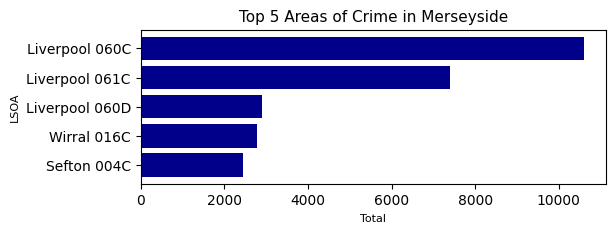

In [284]:
#Visualize the graph to see the top 5 area of crimes in Merseyside
#plt.barh is used to show the horizontal graph
#plt.gca().invert_yaxis() is used to show the highest count on top
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis

plt.figure(figsize=(6, 2))
plt.barh(top_area_M['LSOA_name'], top_area_M['count'], color='darkblue')
plt.xlabel('Total', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('LSOA', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Top 5 Areas of Crime in Merseyside', color = 'Black', fontsize = 11, fontstyle = 'normal', 
          fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

## West Midlands

In [285]:
#create a dataFrame directly from Merseyside county crime csv file 
#https://data.police.uk/data/
Westmidlandscrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/county-datasets/West Midlands_data/*street.csv")

In [286]:
#Check data types
Westmidlandscrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [287]:
#Renaming the columns for consistecy
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('Crime ID', 'Crime_ID')
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('Reported by', 'Reported_by')
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('Falls within', 'Falls_within')
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('LSOA code', 'LSOA_code')
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('LSOA name', 'LSOA_name')
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('Crime type', 'Crime_type')
Westmidlandscrime = Westmidlandscrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [288]:
#Re-check column names
Westmidlandscrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [289]:
#Count total rows/crimes
Westmidlandscrime.count()

750836

In [290]:
#Checking numbers of null values in the column Context
null_context_midlands = Westmidlandscrime.filter(Westmidlandscrime.Context.isNull())
null_context_midlands.count()

750836

In [291]:
#Drop Context column and re_check
Westmidlandscrime = Westmidlandscrime.drop('Context')
Westmidlandscrime

DataFrame[Crime_ID: string, Month: string, Reported_by: string, Falls_within: string, Longitude: double, Latitude: double, Location: string, LSOA_code: string, LSOA_name: string, Crime_type: string, Last_outcome_category: string]

In [292]:
#Check null values in IDs
nullid_midlands = Westmidlandscrime.filter(Westmidlandscrime.Crime_ID.isNull())
nullid_midlands.count()

45120

In [293]:
#Check null value rows for other columns
#https://community.databricks.com/t5/data-engineering/how-to-get-all-occurrences-of-duplicate-records-in-a-pyspark/td-p/19818
nulls_midlands = Westmidlandscrime.groupBy("Crime_ID","Crime_type","Last_outcome_category").count().filter(col("count") > 1)
nulls_midlands.show()

+--------+--------------------+---------------------+-----+
|Crime_ID|          Crime_type|Last_outcome_category|count|
+--------+--------------------+---------------------+-----+
|    null|Anti-social behav...|                 null|45120|
+--------+--------------------+---------------------+-----+



In [294]:
#Retrieve monthly counts of crime
Westmidlandscrime.\
select(substring(Westmidlandscrime.Month, 1,7)\
                                                          \
       .alias('Month'), Westmidlandscrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).collect()

[Row(Month='2022-07', count=34582),
 Row(Month='2022-05', count=34105),
 Row(Month='2022-08', count=33675),
 Row(Month='2022-06', count=33334),
 Row(Month='2022-10', count=32958),
 Row(Month='2022-03', count=32597),
 Row(Month='2023-03', count=32452),
 Row(Month='2022-04', count=31843),
 Row(Month='2022-09', count=31697),
 Row(Month='2023-07', count=31601),
 Row(Month='2023-06', count=31521),
 Row(Month='2023-04', count=31289),
 Row(Month='2022-01', count=31283),
 Row(Month='2022-11', count=30964),
 Row(Month='2023-01', count=30937),
 Row(Month='2023-10', count=30836),
 Row(Month='2023-05', count=30589),
 Row(Month='2023-08', count=29958),
 Row(Month='2022-02', count=29797),
 Row(Month='2023-09', count=29671),
 Row(Month='2023-02', count=29477),
 Row(Month='2022-12', count=29343),
 Row(Month='2023-11', count=28269),
 Row(Month='2023-12', count=28058)]

In [295]:
#Register temporary table to perform sql which is stored in cache memory
Westmidlandscrime.registerTempTable("Westmidlandscrime_table")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [296]:
# Create new data frame with Month and Counts per Month
Westmidlandscrime1 = Westmidlandscrime.select(Westmidlandscrime.Month)\
.groupby(Westmidlandscrime.Month).count()

In [297]:
#retrieve by month
Westmidlandscrime1.orderBy(asc("Month")).show(24)

+-------+-----+
|  Month|count|
+-------+-----+
|2022-01|31283|
|2022-02|29797|
|2022-03|32597|
|2022-04|31843|
|2022-05|34105|
|2022-06|33334|
|2022-07|34582|
|2022-08|33675|
|2022-09|31697|
|2022-10|32958|
|2022-11|30964|
|2022-12|29343|
|2023-01|30937|
|2023-02|29477|
|2023-03|32452|
|2023-04|31289|
|2023-05|30589|
|2023-06|31521|
|2023-07|31601|
|2023-08|29958|
|2023-09|29671|
|2023-10|30836|
|2023-11|28269|
|2023-12|28058|
+-------+-----+



In [298]:
#Register temporary table
Westmidlandscrime1.registerTempTable("Westmidlandscrime1_table")

In [299]:
# Create new dataframe with month, total crime, and average crime
Westmidlands_monthly_crime = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
avg(count) as Average from Westmidlandscrime1_table group by substring(Month, 6, 2)")
Westmidlands_monthly_crime.orderBy(desc("Average")).show()

+-----+-------+
|Month|Average|
+-----+-------+
|   07|33091.5|
|   03|32524.5|
|   06|32427.5|
|   05|32347.0|
|   10|31897.0|
|   08|31816.5|
|   04|31566.0|
|   01|31110.0|
|   09|30684.0|
|   02|29637.0|
|   11|29616.5|
|   12|28700.5|
+-----+-------+



In [300]:
#Retrieve data
Westmidlands_monthly_crime_new = Westmidlands_monthly_crime.orderBy('Month')

In [301]:
# Register temp table for monthly crime
# DataFrame as a temp table and show the contents
#Retrieve total and average data of two years by months
Westmidlands_monthly_crime_new.registerTempTable("Westmidlands_monthly_crime_tb")
sqlContext.sql("select * from Westmidlands_monthly_crime_tb").show(24)

+-----+-------+
|Month|Average|
+-----+-------+
|   01|31110.0|
|   02|29637.0|
|   03|32524.5|
|   04|31566.0|
|   05|32347.0|
|   06|32427.5|
|   07|33091.5|
|   08|31816.5|
|   09|30684.0|
|   10|31897.0|
|   11|29616.5|
|   12|28700.5|
+-----+-------+



In [302]:
#Prepare varibles for visualisation
#Convert dataframe into RDD
monthArray = sqlContext.sql("select Month from Westmidlands_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from Westmidlands_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

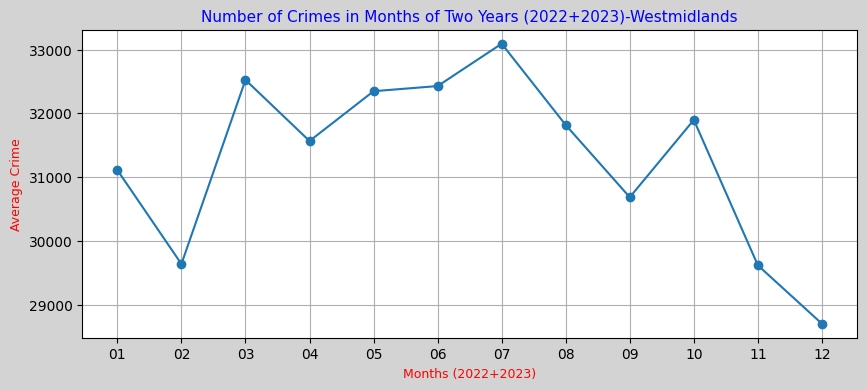

In [303]:
#Plot the monthly visualisation set title, x,y labels, format font
m = monthArray
a = monthAvgArray
plt.figure (figsize = (10,4), facecolor='lightgrey')
plt.plot(m, a, 'o-')
plt.title('Number of Crimes in Months of Two Years (2022+2023)-Westmidlands', color = 'blue', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.xlabel('Months (2022+2023)', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'Calibri(body')
plt.ylabel('Average Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'Calibri(body')
plt.grid(True)
plt.savefig("Westmidlands_monthly_crime.png")
plt.show()

In [304]:
#Create dataframe to retrieve yearly total and average crimes
Westmidlands_yearly_crime = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
Westmidlandscrime1_table group by substring(Month, 0, 4)")

In [305]:
#Register temporary table
Westmidlands_yearly_crime.registerTempTable("Westmidlands_yearly_crime_tb")
sqlContext.sql("select * from Westmidlands_yearly_crime_tb").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|386178|           32181.5|
|2023|364658|30388.166666666668|
+----+------+------------------+



In [306]:
#Prepare variables for visualisation
#Converting dataframe into RDD
totalArray = sqlContext.sql("select Total from Westmidlands_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Westmidlands_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from Westmidlands_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

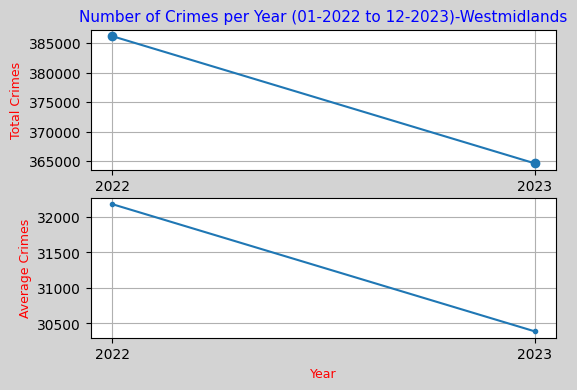

In [307]:
#Plot the yearly visualisation set title, x,y labels, format font
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray
plt.figure (figsize = (6,4), facecolor='lightgrey')

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Number of Crimes per Year (01-2022 to 12-2023)-Westmidlands', color = 'blue', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.ylabel('Total Crimes', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year',  color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crimes',  color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("Westmidlands_yearly_crime.png")
plt.show()

In [308]:
#Register temporary table for crime type
Westmidlandscrime.registerTempTable("Westmidlands_crimetype_table")

In [309]:
#Retrieving crime types 
Westmidlands_crime_types = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year,\
count(*) as Count from Westmidlands_crimetype_table group by Month, Crime_type")
Westmidlands_crime_types.show()

+--------------------+-------+----+-----+
|          Crime_type|  Month|Year|Count|
+--------------------+-------+----+-----+
|Anti-social behav...|2022-03|2022| 1868|
|Possession of wea...|2023-06|2023|  666|
|       Vehicle crime|2023-03|2023| 3312|
|         Shoplifting|2023-03|2023| 2133|
|Theft from the pe...|2023-06|2023|  303|
|Possession of wea...|2022-05|2022|  676|
|Criminal damage a...|2022-07|2022| 2607|
|               Drugs|2022-10|2022|  688|
|Possession of wea...|2022-10|2022|  647|
|        Public order|2023-03|2023| 2663|
|Criminal damage a...|2022-08|2022| 2815|
|       Vehicle crime|2023-06|2023| 2692|
|            Burglary|2022-07|2022| 1661|
|Theft from the pe...|2022-05|2022|  324|
|Violence and sexu...|2022-04|2022|13515|
|        Public order|2022-07|2022| 3166|
|         Other crime|2022-08|2022|  541|
|       Vehicle crime|2022-01|2022| 3051|
|       Vehicle crime|2022-06|2022| 2873|
|         Other theft|2022-06|2022| 2208|
+--------------------+-------+----

In [310]:
#Retreiving crime types in descending order
Westmidlandscrime.groupby ("Crime_type").count().orderBy (desc("count")).show()

+--------------------+------+
|          Crime_type| count|
+--------------------+------+
|Violence and sexu...|312698|
|       Vehicle crime| 72984|
|        Public order| 58852|
|Criminal damage a...| 57020|
|         Other theft| 50618|
|Anti-social behav...| 45120|
|            Burglary| 41450|
|         Shoplifting| 40003|
|             Robbery| 17015|
|               Drugs| 15589|
|Possession of wea...| 13891|
|         Other crime| 12482|
|Theft from the pe...|  8372|
|       Bicycle theft|  4742|
+--------------------+------+



In [311]:
crimetype_W = Westmidlandscrime.groupby ("Crime_type").count().orderBy (desc("count")).toPandas()

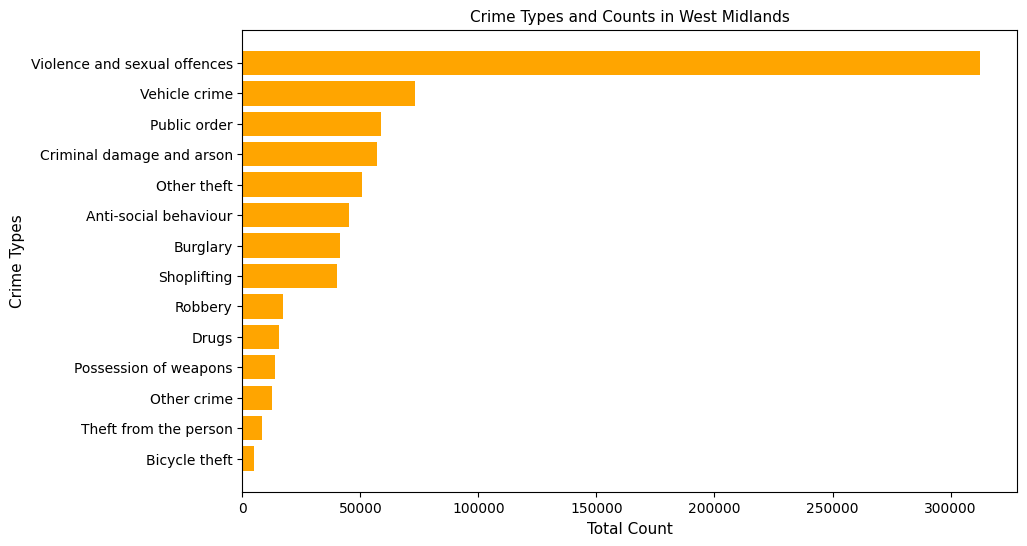

In [312]:
#Visualize the types of crime and the counts
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
plt.figure(figsize=(10, 6))
plt.barh(crimetype_W['Crime_type'], crimetype_W['count'], color='orange')
plt.xlabel('Total Count', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Crime Types', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Crime Types and Counts in West Midlands', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.gca().invert_yaxis() 
plt.show()

In [313]:
#Retreiving outcomes in descending order
Westmidlandscrime.groupby ("Last_outcome_category").count().orderBy (desc("count")).show(truncate=False)

+---------------------------------------------------+------+
|Last_outcome_category                              |count |
+---------------------------------------------------+------+
|Unable to prosecute suspect                        |356030|
|Investigation complete; no suspect identified      |271914|
|null                                               |45120 |
|Court result unavailable                           |26887 |
|Status update unavailable                          |22313 |
|Action to be taken by another organisation         |10525 |
|Local resolution                                   |9955  |
|Offender given a caution                           |3200  |
|Awaiting court outcome                             |2330  |
|Further action is not in the public interest       |1165  |
|Further investigation is not in the public interest|583   |
|Suspect charged as part of another case            |441   |
|Formal action is not in the public interest        |373   |
+-----------------------

In [314]:
# Extract the city name from 'LSOA_name' by splitting the string at the space and taking the first part
merge_w = Westmidlandscrime.withColumn('City', F.split('LSOA_name', ' ').getItem(0))

# Group by the extracted city and count the number of crimes for each city
topcity_w = merge_w.groupby('City').agg(F.count('Crime_ID').alias('Total_Crimes'))

# Sort by Total_Crimes in descending order
topcity_w = topcity_w.orderBy(F.desc('Total_Crimes')).limit(5).toPandas()
topcity_w

,City,Total_Crimes
0,Birmingham,311588
1,Coventry,82384
2,Sandwell,78206
3,Wolverhampton,67896
4,Walsall,64787


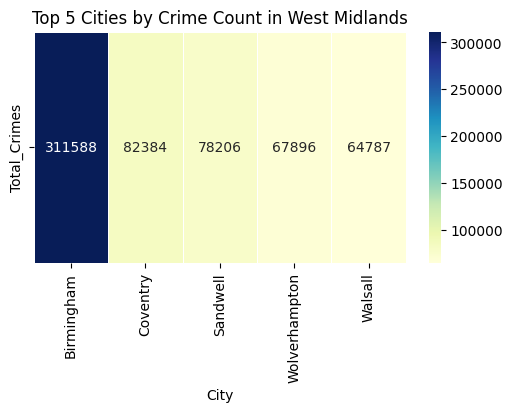

In [315]:
#setting city as index, transposing=swapping columns and rows
heatmap_w = topcity_w.set_index("City")["Total_Crimes"].to_frame().transpose()
#Plot the heatmap using Seaborn
plt.figure(figsize=(6, 3))  # Adjusted figure size for better clarity
sns.heatmap(heatmap_w, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5)

plt.title('Top 5 Cities by Crime Count in West Midlands', color='Black', fontsize=12, fontstyle='normal', fontname='calibri(body)')
plt.show()

In [316]:
#Retrieving the top 5 area by total crime count descending order
top_area_W = Westmidlandscrime.select("LSOA_name").groupby("LSOA_name")\
            .count().orderBy(desc("count")).limit(5).toPandas()
top_area_W

,LSOA_name,count
0,Birmingham 138A,11105
1,Birmingham 135C,5510
2,Coventry 031C,5490
3,Wolverhampton 020F,4616
4,Walsall 030A,4496


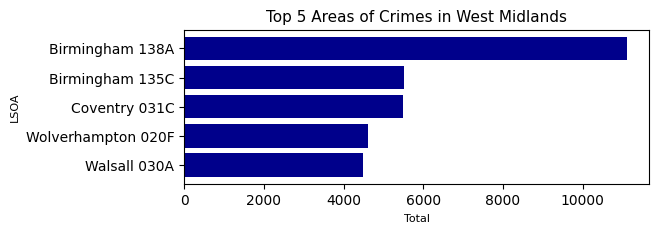

In [317]:
#Visualize the graph to see the top 5 areas of crime in West Midlands
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis

plt.figure(figsize=(6, 2))
plt.barh(top_area_W['LSOA_name'], top_area_W['count'], color='darkblue')
plt.xlabel('Total', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('LSOA', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Top 5 Areas of Crimes in West Midlands', color = 'Black', fontsize = 11, fontstyle = 'normal', 
          fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

## West Yorkshire

In [318]:
#create a dataFrame directly from West Yorkshire county crime csv file 
Westyorkshirecrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/county-datasets/West Yorkshire_data/*street.csv")

In [319]:
#Check data types
Westyorkshirecrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [320]:
#Renaming the columns for consistecy
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('Crime ID', 'Crime_ID')
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('Reported by', 'Reported_by')
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('Falls within', 'Falls_within')
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('LSOA code', 'LSOA_code')
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('LSOA name', 'LSOA_name')
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('Crime type', 'Crime_type')
Westyorkshirecrime = Westyorkshirecrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [321]:
#Re-check column names
Westyorkshirecrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [322]:
#Count total rows/crimes
Westyorkshirecrime.count()

675336

In [323]:
#Checking numbers of null values in the column Context
null_context_york = Westyorkshirecrime.filter(Westyorkshirecrime.Context.isNull())
null_context_york.count()

675336

In [324]:
#Drop Context column and re_check
Westyorkshirecrime = Westyorkshirecrime.drop('Context')
Westyorkshirecrime

DataFrame[Crime_ID: string, Month: string, Reported_by: string, Falls_within: string, Longitude: double, Latitude: double, Location: string, LSOA_code: string, LSOA_name: string, Crime_type: string, Last_outcome_category: string]

In [325]:
#Check null values in IDs
nullid_york = Westyorkshirecrime.filter(Westyorkshirecrime.Crime_ID.isNull())
nullid_york.count()

55181

In [326]:
#Retrieve monthly counts of crime
Westyorkshirecrime.\
select(substring(Westyorkshirecrime.Month, 1,7)\
                                                          \
       .alias('Month'), Westyorkshirecrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).collect()

[Row(Month='2022-05', count=31102),
 Row(Month='2022-08', count=31074),
 Row(Month='2022-07', count=31037),
 Row(Month='2023-05', count=30936),
 Row(Month='2022-06', count=29534),
 Row(Month='2022-03', count=29413),
 Row(Month='2023-03', count=29309),
 Row(Month='2022-10', count=29188),
 Row(Month='2023-06', count=29165),
 Row(Month='2023-04', count=28841),
 Row(Month='2023-07', count=28520),
 Row(Month='2022-04', count=28505),
 Row(Month='2022-09', count=28446),
 Row(Month='2023-10', count=27834),
 Row(Month='2022-11', count=27825),
 Row(Month='2023-08', count=27798),
 Row(Month='2023-09', count=27478),
 Row(Month='2023-01', count=27442),
 Row(Month='2023-02', count=27140),
 Row(Month='2022-01', count=26538),
 Row(Month='2022-02', count=25115),
 Row(Month='2023-11', count=24962),
 Row(Month='2022-12', count=24601),
 Row(Month='2023-12', count=23533)]

In [327]:
#Retrieve counts for each year ordered in descending order
Westyorkshirecrime.select(substring(Westyorkshirecrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+------+
|Year| count|
+----+------+
|2022|342378|
|2023|332958|
+----+------+



In [328]:
#Register temporary table to perform sql which is stored in cache memory
Westyorkshirecrime.registerTempTable("Westyorkshirecrime_table")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [329]:
# Create new data frame with Month and Counts per Month
Westyorkshirecrime1 = Westyorkshirecrime.select(Westyorkshirecrime.Month)\
.groupby(Westyorkshirecrime.Month).count()

In [330]:
#Retrieve monthly crime in descending order
Westyorkshirecrime1.orderBy(desc("Count")).show(24)

+-------+-----+
|  Month|count|
+-------+-----+
|2022-05|31102|
|2022-08|31074|
|2022-07|31037|
|2023-05|30936|
|2022-06|29534|
|2022-03|29413|
|2023-03|29309|
|2022-10|29188|
|2023-06|29165|
|2023-04|28841|
|2023-07|28520|
|2022-04|28505|
|2022-09|28446|
|2023-10|27834|
|2022-11|27825|
|2023-08|27798|
|2023-09|27478|
|2023-01|27442|
|2023-02|27140|
|2022-01|26538|
|2022-02|25115|
|2023-11|24962|
|2022-12|24601|
|2023-12|23533|
+-------+-----+



In [331]:
#Register temporary table
Westyorkshirecrime1.registerTempTable("Westyorkshirecrime1_table")

In [332]:
# Create new dataframe with month, total crime, and average crime
Westyorkshire_monthly_crime = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
avg(count) as average from Westyorkshirecrime1_table group by substring(Month, 6, 2)")
Westyorkshire_monthly_crime.orderBy(desc("Average")).show()

+-----+-------+
|Month|average|
+-----+-------+
|   05|31019.0|
|   07|29778.5|
|   08|29436.0|
|   03|29361.0|
|   06|29349.5|
|   04|28673.0|
|   10|28511.0|
|   09|27962.0|
|   01|26990.0|
|   11|26393.5|
|   02|26127.5|
|   12|24067.0|
+-----+-------+



In [333]:
#Retrieve data
Westyorkshire_monthly_crime_new = Westyorkshire_monthly_crime.orderBy('Month')

In [334]:
# Register temp table for monthly crime
# DataFrame as a temp table and show the contents
Westyorkshire_monthly_crime_new.registerTempTable("Westyorkshire_monthly_crime_tb")
#Retrieve total and average data of two years by months
sqlContext.sql("select * from Westyorkshire_monthly_crime_tb").show(24)

+-----+-------+
|Month|average|
+-----+-------+
|   01|26990.0|
|   02|26127.5|
|   03|29361.0|
|   04|28673.0|
|   05|31019.0|
|   06|29349.5|
|   07|29778.5|
|   08|29436.0|
|   09|27962.0|
|   10|28511.0|
|   11|26393.5|
|   12|24067.0|
+-----+-------+



In [335]:
#Prepare varibles for visualisation
#Convert dataframe into RDD
monthArray = sqlContext.sql("select Month from Westyorkshire_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from Westyorkshire_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

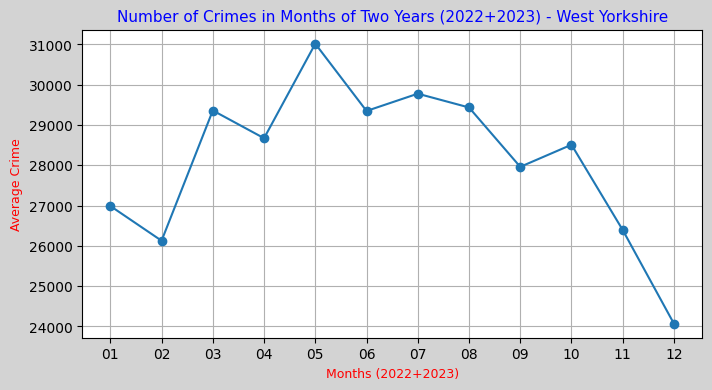

In [336]:
#Plot the monthly visualisation set title, x,y labels, format font
m = monthArray
a = monthAvgArray
plt.figure(figsize = (8,4), facecolor = 'lightgrey')
plt.plot(m, a, 'o-')
plt.title('Number of Crimes in Months of Two Years (2022+2023) - West Yorkshire', color = 'blue', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.xlabel('Months (2022+2023)', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(head)')
plt.ylabel('Average Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(head)')
plt.grid(True)
plt.savefig("Westmidlands_monthly_crime.png")
plt.show()

In [337]:
#Create dataframe to retrieve yearly total and average crimes
Westyorkshire_yearly_crime = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
Westyorkshirecrime1_table group by substring(Month, 0, 4)")

In [338]:
#Register temporary table for yearly crime
Westyorkshire_yearly_crime.registerTempTable("Westyorkshire_yearly_crime_tb")
sqlContext.sql("select * from Westyorkshire_yearly_crime_tb").show()

+----+------+-------+
|Year| Total|Average|
+----+------+-------+
|2022|342378|28531.5|
|2023|332958|27746.5|
+----+------+-------+



In [339]:
#Prepare variables for visualisation
#Converting dataframe into RDD
totalArray = sqlContext.sql("select Total from Westyorkshire_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Westyorkshire_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from Westyorkshire_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

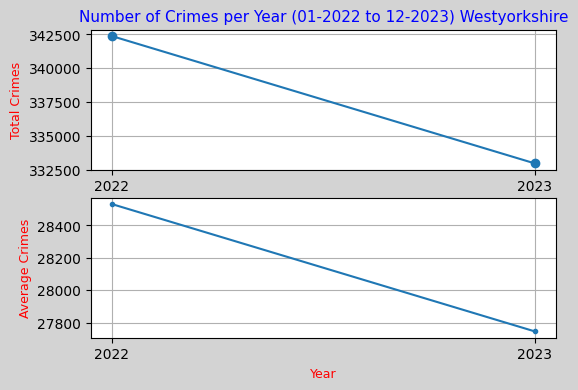

In [340]:
#Plot the yearly visualisation set title, x,y labels, format font
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray
plt.figure(figsize = (6,4), facecolor = 'lightgrey')

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Number of Crimes per Year (01-2022 to 12-2023) Westyorkshire', color = 'blue', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.ylabel('Total Crimes', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crimes', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("Westyorkshire_yearly_crime.png")
plt.show()

In [341]:
#Retreiving crime types in descending order by count
Westyorkshirecrime.groupby ("Crime_type").count().orderBy (desc("count")).show()

+--------------------+------+
|          Crime_type| count|
+--------------------+------+
|Violence and sexu...|279815|
|        Public order| 78810|
|Criminal damage a...| 55314|
|Anti-social behav...| 55181|
|         Other theft| 44412|
|         Shoplifting| 40032|
|       Vehicle crime| 34528|
|            Burglary| 30029|
|               Drugs| 17928|
|         Other crime| 16618|
|Theft from the pe...|  6788|
|             Robbery|  6277|
|Possession of wea...|  5417|
|       Bicycle theft|  4187|
+--------------------+------+



In [342]:
crimetype_Y = Westyorkshirecrime.groupby ("Crime_type").count().orderBy (desc("count")).toPandas()

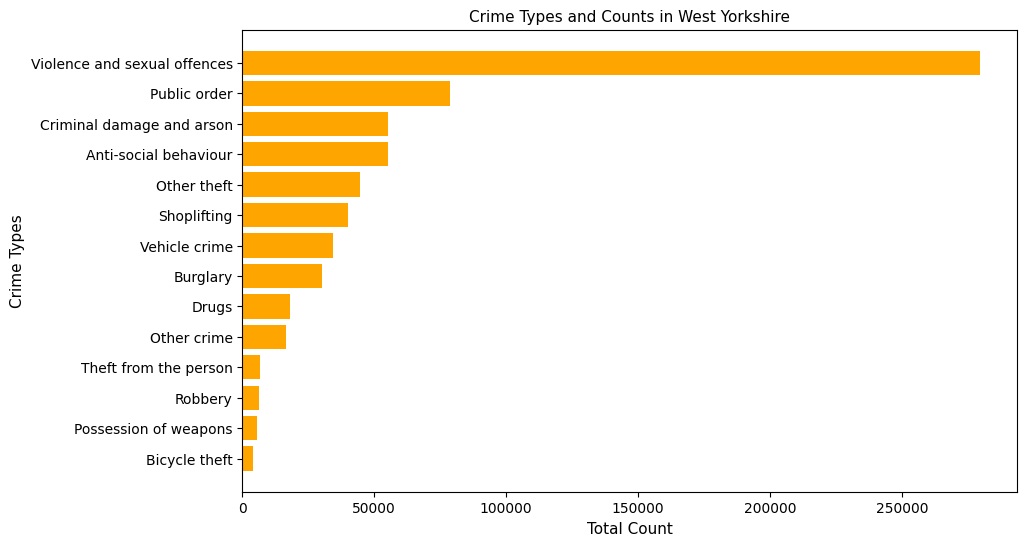

In [343]:
#Visualize the types of crime and the counts
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
crimetype_Y = Westyorkshirecrime.groupby ("Crime_type").count().orderBy (desc("count")).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(crimetype_Y['Crime_type'], crimetype_Y['count'], color='orange')
plt.xlabel('Total Count', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Crime Types', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Crime Types and Counts in West Yorkshire', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

In [344]:
#Retreiving outcomes in descending order
Westyorkshirecrime.groupby ("Last_outcome_category").count().orderBy (desc("count")).show(truncate=False)

+---------------------------------------------------+------+
|Last_outcome_category                              |count |
+---------------------------------------------------+------+
|Unable to prosecute suspect                        |270471|
|Investigation complete; no suspect identified      |240860|
|null                                               |55181 |
|Court result unavailable                           |39944 |
|Status update unavailable                          |31433 |
|Local resolution                                   |12810 |
|Action to be taken by another organisation         |7661  |
|Offender given a caution                           |5095  |
|Further investigation is not in the public interest|4882  |
|Further action is not in the public interest       |2677  |
|Awaiting court outcome                             |2315  |
|Formal action is not in the public interest        |1671  |
|Suspect charged as part of another case            |332   |
|Offender given penalty 

In [345]:
# Extract the city name from 'LSOA_name' by splitting the string at the space and taking the first part
merge_y = Westyorkshirecrime.withColumn('City', F.split('LSOA_name', ' ').getItem(0))

# Group by the extracted city and count the number of crimes for each city
topcity_y = merge_y.groupby('City').agg(F.count('Crime_ID').alias('Total_Crimes'))

# Sort by Total_Crimes in descending order
topcity_y = topcity_y.orderBy(F.desc('Total_Crimes')).limit(5).toPandas()
topcity_y

,City,Total_Crimes
0,Leeds,222499
1,Bradford,148658
2,Wakefield,93481
3,Kirklees,93048
4,Calderdale,51408


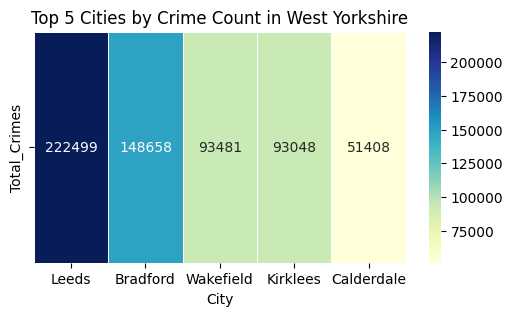

In [346]:
#setting city as index, transposing=swapping columns and rows
heatmap_y = topcity_y.set_index("City")["Total_Crimes"].to_frame().transpose()
#Plot the heatmap using Seaborn
plt.figure(figsize=(6, 3))  # Adjusted figure size for better clarity
sns.heatmap(heatmap_y, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5)
plt.title('Top 5 Cities by Crime Count in West Yorkshire', color='Black', fontsize=12, fontstyle='normal', fontname='calibri(body)')
plt.show()

In [347]:
#Retreiving top 5 areas of crime
top_area_Y = Westyorkshirecrime.select("LSOA_name").groupby("LSOA_name")\
            .count().orderBy(desc("count")).limit(5).toPandas()
top_area_Y
#Null value is found and needed to drop since the visualisation does not support null values 

,LSOA_name,count
0,Leeds 111B,15729
1,None,11325
2,Bradford 039G,5032
3,Kirklees 029D,4949
4,Calderdale 008E,4453


In [348]:
#since the null value is found, the row with null value is dropped and retrieve the top 5 areas again
top_area1_Y=Westyorkshirecrime.select("LSOA_name").groupby("LSOA_name").\
            count().orderBy(desc("count")).dropna(subset=['LSOA_name']).limit(5).toPandas()
top_area1_Y

,LSOA_name,count
0,Leeds 111B,15729
1,Bradford 039G,5032
2,Kirklees 029D,4949
3,Calderdale 008E,4453
4,Kirklees 017B,3679


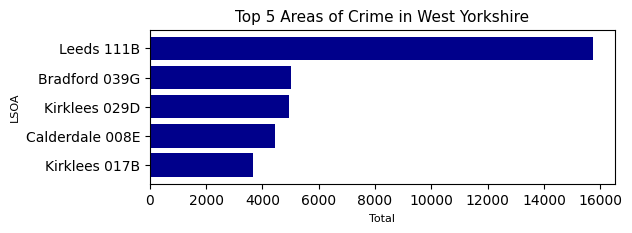

In [349]:
#Visualize the graph to see the top 5 areas of crime in West Yorkshire
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
plt.figure(figsize=(6, 2))
plt.barh(top_area1_Y['LSOA_name'], top_area1_Y['count'], color='darkblue')
plt.xlabel('Total', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('LSOA', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Top 5 Areas of Crime in West Yorkshire', color = 'Black', fontsize = 11, fontstyle = 'normal', 
          fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

## Nottinghamshire

In [350]:
#create a dataFrame directly from Nottingham county crime csv file 
Nottinghamcrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/county-datasets/Norttinghamshire_data/*street.csv")

In [351]:
#Check data types
Nottinghamcrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [352]:
#Renaming the columns for consistecy
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('Crime ID', 'Crime_ID')
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('Reported by', 'Reported_by')
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('Falls within', 'Falls_within')
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('LSOA code', 'LSOA_code')
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('LSOA name', 'LSOA_name')
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('Crime type', 'Crime_type')
Nottinghamcrime = Nottinghamcrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [353]:
#Re-check column names
Nottinghamcrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [354]:
#Count total rows/crimes
Nottinghamcrime.count()

248169

In [355]:
#Checking numbers of null values in the column Context with isNull
null_Context_nott = Nottinghamcrime.filter(Nottinghamcrime.Context.isNull())
null_Context_nott.count()

248169

In [356]:
#Drop Context column and re_check
Nottinghamcrime = Nottinghamcrime.drop('Context')
Nottinghamcrime

DataFrame[Crime_ID: string, Month: string, Reported_by: string, Falls_within: string, Longitude: double, Latitude: double, Location: string, LSOA_code: string, LSOA_name: string, Crime_type: string, Last_outcome_category: string]

In [357]:
#Check null values in ID
nullid_nott = Nottinghamcrime.filter(Nottinghamcrime.Crime_ID.isNull())
nullid_nott.count()

38549

In [358]:
#Retrieve monthly counts of crime
Nottinghamcrime.\
select(substring(Nottinghamcrime.Month, 1,7)\
                                                          \
       .alias('Month'), Nottinghamcrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).collect()

[Row(Month='2023-05', count=12471),
 Row(Month='2022-05', count=12400),
 Row(Month='2023-06', count=12346),
 Row(Month='2022-08', count=11923),
 Row(Month='2023-07', count=11876),
 Row(Month='2022-04', count=11820),
 Row(Month='2022-03', count=11742),
 Row(Month='2023-04', count=11737),
 Row(Month='2023-03', count=11640),
 Row(Month='2023-02', count=10889),
 Row(Month='2022-11', count=10808),
 Row(Month='2022-02', count=10404),
 Row(Month='2023-11', count=10092),
 Row(Month='2022-12', count=9572),
 Row(Month='2022-07', count=9552),
 Row(Month='2022-10', count=9508),
 Row(Month='2022-06', count=9262),
 Row(Month='2023-09', count=8976),
 Row(Month='2023-01', count=8914),
 Row(Month='2023-08', count=8838),
 Row(Month='2023-10', count=8755),
 Row(Month='2022-09', count=8597),
 Row(Month='2022-01', count=8562),
 Row(Month='2023-12', count=7485)]

In [359]:
#Retrieve counts for each year ordered in descending order
Nottinghamcrime.select(substring(Nottinghamcrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+------+
|Year| count|
+----+------+
|2022|124150|
|2023|124019|
+----+------+



In [360]:
#Register temporary table to perform sql which is stored in cache memory
Nottinghamcrime.registerTempTable("Nottinghamcrime_table")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [361]:
# Create new data frame with Month and Counts per Month
Nottinghamcrime1 = Nottinghamcrime.select(Nottinghamcrime.Month)\
.groupby(Nottinghamcrime.Month).count()

In [362]:
#Retrieve monthly crime in descending order
Nottinghamcrime1.orderBy(desc("Count")).show(24)

+-------+-----+
|  Month|count|
+-------+-----+
|2023-05|12471|
|2022-05|12400|
|2023-06|12346|
|2022-08|11923|
|2023-07|11876|
|2022-04|11820|
|2022-03|11742|
|2023-04|11737|
|2023-03|11640|
|2023-02|10889|
|2022-11|10808|
|2022-02|10404|
|2023-11|10092|
|2022-12| 9572|
|2022-07| 9552|
|2022-10| 9508|
|2022-06| 9262|
|2023-09| 8976|
|2023-01| 8914|
|2023-08| 8838|
|2023-10| 8755|
|2022-09| 8597|
|2022-01| 8562|
|2023-12| 7485|
+-------+-----+



In [363]:
Nottinghamcrime1.orderBy(asc("Month")).show(24)

+-------+-----+
|  Month|count|
+-------+-----+
|2022-01| 8562|
|2022-02|10404|
|2022-03|11742|
|2022-04|11820|
|2022-05|12400|
|2022-06| 9262|
|2022-07| 9552|
|2022-08|11923|
|2022-09| 8597|
|2022-10| 9508|
|2022-11|10808|
|2022-12| 9572|
|2023-01| 8914|
|2023-02|10889|
|2023-03|11640|
|2023-04|11737|
|2023-05|12471|
|2023-06|12346|
|2023-07|11876|
|2023-08| 8838|
|2023-09| 8976|
|2023-10| 8755|
|2023-11|10092|
|2023-12| 7485|
+-------+-----+



In [364]:
#Register temporary table
Nottinghamcrime1.registerTempTable("Nottinghamcrime1_table")

In [365]:
# Create new dataframe with month, total crime, and average crime
Nottingham_monthly_crime = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
avg(count) as Average from Nottinghamcrime1_table group by substring(Month, 6, 2)")
Nottingham_monthly_crime.orderBy(desc("Average")).show()

+-----+-------+
|Month|Average|
+-----+-------+
|   05|12435.5|
|   04|11778.5|
|   03|11691.0|
|   06|10804.0|
|   07|10714.0|
|   02|10646.5|
|   11|10450.0|
|   08|10380.5|
|   10| 9131.5|
|   09| 8786.5|
|   01| 8738.0|
|   12| 8528.5|
+-----+-------+



In [366]:
#Retrieve data
Nottingham_monthly_crime_new = Nottingham_monthly_crime.orderBy('Month')

In [367]:
# Register temp table for monthly crime
# DataFrame as a temp table and show the contents
Nottingham_monthly_crime_new.registerTempTable("Nottingham_monthly_crime_tb")
#Retrieve total and average data of two years by months
sqlContext.sql("select * from Nottingham_monthly_crime_tb").show(24)

+-----+-------+
|Month|Average|
+-----+-------+
|   01| 8738.0|
|   02|10646.5|
|   03|11691.0|
|   04|11778.5|
|   05|12435.5|
|   06|10804.0|
|   07|10714.0|
|   08|10380.5|
|   09| 8786.5|
|   10| 9131.5|
|   11|10450.0|
|   12| 8528.5|
+-----+-------+



In [368]:
#Prepare varibles for visualisation
#Convert dataframe into RDD
monthArray = sqlContext.sql("select Month from Nottingham_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from Nottingham_monthly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

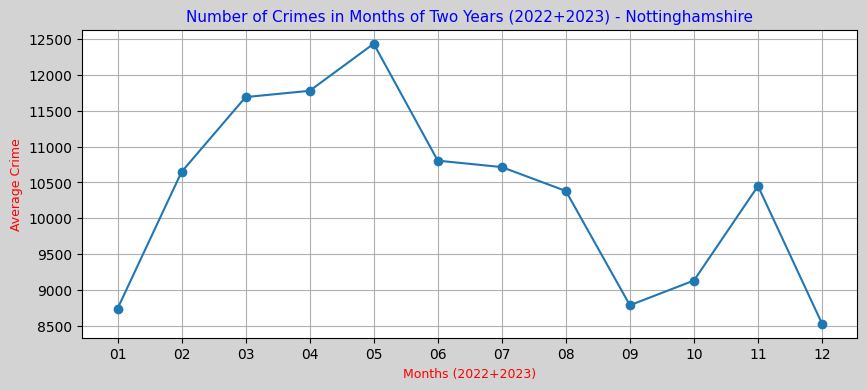

In [369]:
#Plot the monthly visualisation set title, x,y labels, format font
m = monthArray
a = monthAvgArray
plt.figure(figsize = (10,4), facecolor = 'lightgrey')
plt.plot(m, a, 'o-')
plt.title('Number of Crimes in Months of Two Years (2022+2023) - Nottinghamshire', color = 'blue', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.xlabel('Months (2022+2023)', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crime', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("Westmidlands_monthly_crime.png")
plt.show()

In [370]:
#Create dataframe to retrieve yearly total and average crimes
Nottingham_yearly_crime = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
Nottinghamcrime1_table group by substring(Month, 0, 4)")

In [371]:
#Register temporary table for yearly crime
Nottingham_yearly_crime.registerTempTable("Nottingham_yearly_crime_tb")
sqlContext.sql("select * from Nottingham_yearly_crime_tb").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|124150|10345.833333333334|
|2023|124019|10334.916666666666|
+----+------+------------------+



In [372]:
#Prepare variables for visualisation
#Converting dataframe into RDD
totalArray = sqlContext.sql("select Total from Nottingham_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Nottingham_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from Nottingham_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

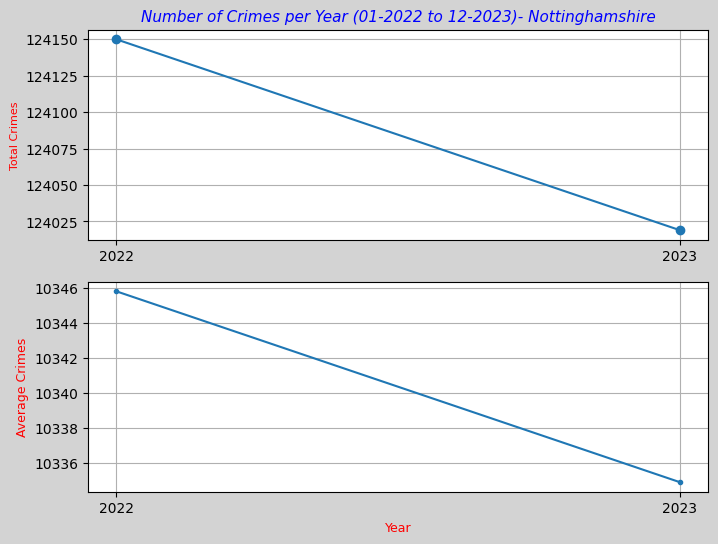

In [373]:
#Plot the yearly visualisation set title, x,y labels, format font
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray
plt.figure(figsize = (8,6), facecolor = 'lightgrey')

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Number of Crimes per Year (01-2022 to 12-2023)- Nottinghamshire', color = 'blue', fontsize = 11, fontstyle = 'italic', fontname = 'calibri(head)')
plt.ylabel('Total Crimes', color = 'red', fontsize = 8)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Crimes', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.savefig("Nottinghamshire_yearly_crime.png")
plt.show()

In [374]:
sqlContext.sql("select Month, substring(Month, 0, 4)\
as Year, count(*) as Count from Nottinghamcrime_table group by Month  order by Month asc").show(24)

+-------+----+-----+
|  Month|Year|Count|
+-------+----+-----+
|2022-01|2022| 8562|
|2022-02|2022|10404|
|2022-03|2022|11742|
|2022-04|2022|11820|
|2022-05|2022|12400|
|2022-06|2022| 9262|
|2022-07|2022| 9552|
|2022-08|2022|11923|
|2022-09|2022| 8597|
|2022-10|2022| 9508|
|2022-11|2022|10808|
|2022-12|2022| 9572|
|2023-01|2023| 8914|
|2023-02|2023|10889|
|2023-03|2023|11640|
|2023-04|2023|11737|
|2023-05|2023|12471|
|2023-06|2023|12346|
|2023-07|2023|11876|
|2023-08|2023| 8838|
|2023-09|2023| 8976|
|2023-10|2023| 8755|
|2023-11|2023|10092|
|2023-12|2023| 7485|
+-------+----+-----+



In [375]:
Nottinghamcrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)



In [376]:
#Register temporary table for crime type
Nottinghamcrime.registerTempTable("Nottingham_crimetype_tb")

In [377]:
#Retreiving crime types in descending order
Nottinghamcrime.groupby ("Crime_type").count().orderBy (desc("count")).show(truncate=False)

+----------------------------+-----+
|Crime_type                  |count|
+----------------------------+-----+
|Violence and sexual offences|78965|
|Anti-social behaviour       |38549|
|Shoplifting                 |26606|
|Criminal damage and arson   |22767|
|Other theft                 |17840|
|Public order                |17539|
|Vehicle crime               |12137|
|Burglary                    |9703 |
|Drugs                       |8072 |
|Other crime                 |5966 |
|Possession of weapons       |3071 |
|Bicycle theft               |2773 |
|Robbery                     |2163 |
|Theft from the person       |2018 |
+----------------------------+-----+



In [378]:
crimetype_N = Nottinghamcrime.groupby ("Crime_type").count().orderBy (desc("count")).toPandas()

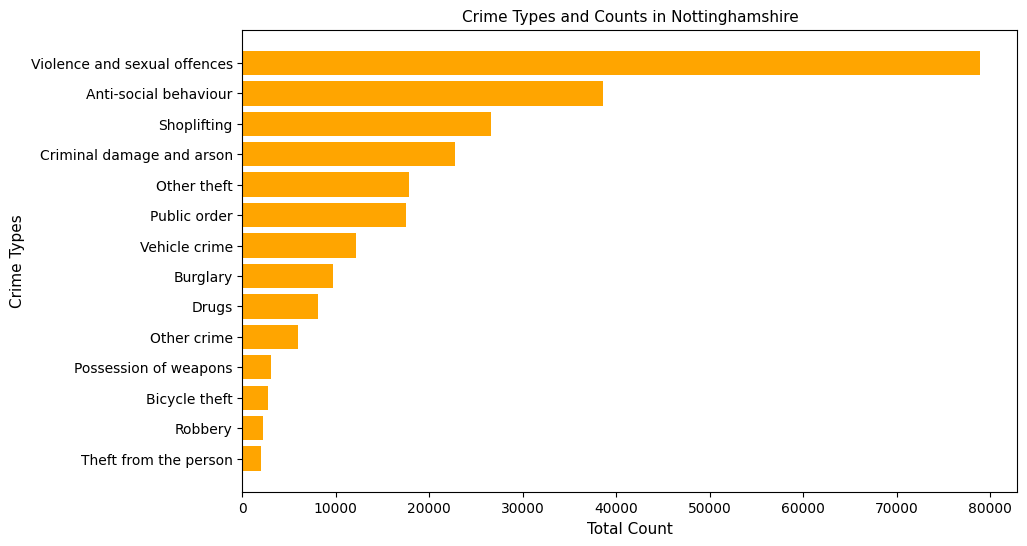

In [379]:
#Visualize the types of crime and the counts
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
plt.figure(figsize=(10, 6))
plt.barh(crimetype_N['Crime_type'], crimetype_N['count'], color='orange')
plt.xlabel('Total Count', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Crime Types', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Crime Types and Counts in Nottinghamshire', color = 'Black', fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.gca().invert_yaxis() 
plt.show()

In [380]:
#Retreiving outcomes in descending order
Nottinghamcrime.groupby ("Last_outcome_category").count().orderBy (desc("count")).show(truncate=False)

+---------------------------------------------------+-----+
|Last_outcome_category                              |count|
+---------------------------------------------------+-----+
|Investigation complete; no suspect identified      |90298|
|Unable to prosecute suspect                        |76663|
|null                                               |38549|
|Court result unavailable                           |19061|
|Local resolution                                   |5503 |
|Status update unavailable                          |3383 |
|Action to be taken by another organisation         |3342 |
|Offender given a caution                           |2870 |
|Formal action is not in the public interest        |2240 |
|Further investigation is not in the public interest|2196 |
|Further action is not in the public interest       |1703 |
|Awaiting court outcome                             |1075 |
|Offender given a drugs possession warning          |852  |
|Offender given penalty notice          

In [381]:
# Extract the city name from 'LSOA_name' by splitting the string at the space and taking the first part
merge_n = Nottinghamcrime.withColumn('City', F.split('LSOA_name', ' ').getItem(0))

# Group by the extracted city and count the number of crimes for each city
topcity_n = merge_n.groupby('City').agg(F.count('Crime_ID').alias('Total_Crimes'))

# Sort by Total_Crimes in descending order
topcity_n = topcity_n.orderBy(F.desc('Total_Crimes')).limit(5).toPandas()
topcity_n

,City,Total_Crimes
0,Nottingham,83024
1,Mansfield,24124
2,Ashfield,22241
3,Bassetlaw,20978
4,Newark,17578


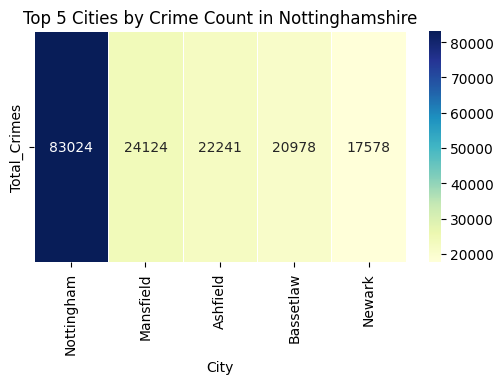

In [382]:
#setting city as index, transposing=swapping columns and rows
heatmap_n = topcity_n.set_index("City")["Total_Crimes"].to_frame().transpose()
#Plot the heatmap using Seaborn
plt.figure(figsize=(6, 3))  # Adjusted figure size for better clarity
sns.heatmap(heatmap_n, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5)
plt.title('Top 5 Cities by Crime Count in Nottinghamshire', color='Black', fontsize=12, fontstyle='normal', fontname='calibri(body)')
plt.show()

In [383]:
top_area_N = Nottinghamcrime.groupby ("LSOA_name").count().\
            orderBy (desc("count")).limit(5).toPandas()
top_area_N

,LSOA_name,count
0,Nottingham 039B,3881
1,Nottingham 039E,3864
2,Mansfield 008D,2628
3,Mansfield 008F,2591
4,Newark and Sherwood 007F,2552


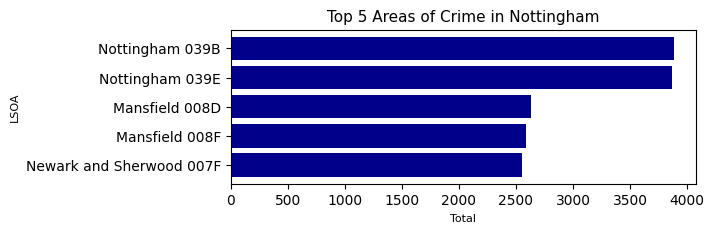

In [384]:
#Visualize the graph to see the top 5 areas of crime in Nottingham
#https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis

plt.figure(figsize=(6, 2))
plt.barh(top_area_N['LSOA_name'], top_area_N['count'], color='darkblue')
plt.xlabel('Total', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('LSOA', color = 'Black', fontsize = 8, fontstyle = 'normal', fontname = 'calibri(body)')
plt.title('Top 5 Areas of Crime in Nottingham', color = 'Black', fontsize = 11, fontstyle = 'normal', 
          fontname = 'calibri(head)')
plt.gca().invert_yaxis()  
plt.show()

## Joining Tables To Compare The Average Monthly Crimes of Four Counties
## Comparing Average Monthly and Yearly Crimes

In [385]:
#Join the first two tables (Merseyside and Westmidlands) by month
df_joined_tb = Merseyside_monthly_crime_new.join(Westmidlands_monthly_crime_new, \
                Merseyside_monthly_crime_new["Month"] == Westmidlands_monthly_crime_new["Month"], "outer")

In [386]:
#Differentiate and rename the two average count columns and retrieve data 
df_joined_tb = df_joined_tb.select(
     Merseyside_monthly_crime_new["Month"],
    Merseyside_monthly_crime_new["Average"].alias("avgcount_M"), 
    Westmidlands_monthly_crime_new["Average"].alias("avgcount_W"), 
   )
df_joined_tb.show()

+-----+----------+----------+
|Month|avgcount_M|avgcount_W|
+-----+----------+----------+
|   01|   14588.0|   31110.0|
|   02|   14127.0|   29637.0|
|   03|   15667.0|   32524.5|
|   04|   15044.5|   31566.0|
|   05|   16395.5|   32347.0|
|   06|   15462.5|   32427.5|
|   07|   14862.0|   33091.5|
|   08|   15126.5|   31816.5|
|   09|   14413.0|   30684.0|
|   10|   14683.5|   31897.0|
|   11|   13941.5|   29616.5|
|   12|   12527.0|   28700.5|
+-----+----------+----------+



In [387]:
#Register temporary joined table
df_joined_tb.registerTempTable("df_joined_tb")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [388]:
sqlContext.sql("select * from df_joined_tb").show(24)

+-----+----------+----------+
|Month|avgcount_M|avgcount_W|
+-----+----------+----------+
|   01|   14588.0|   31110.0|
|   02|   14127.0|   29637.0|
|   03|   15667.0|   32524.5|
|   04|   15044.5|   31566.0|
|   05|   16395.5|   32347.0|
|   06|   15462.5|   32427.5|
|   07|   14862.0|   33091.5|
|   08|   15126.5|   31816.5|
|   09|   14413.0|   30684.0|
|   10|   14683.5|   31897.0|
|   11|   13941.5|   29616.5|
|   12|   12527.0|   28700.5|
+-----+----------+----------+



In [389]:
#Join the last two tables (West Yorkshire and Nottingham)
df_joined_tb1 = Westyorkshire_monthly_crime_new.join(Nottingham_monthly_crime_new,\
                Westyorkshire_monthly_crime_new["Month"] == Nottingham_monthly_crime_new["Month"], "outer")

In [390]:
#Differentiate and rename the two average count columns and retrieve data 
df_joined_tb1 = df_joined_tb1.select(
    Westyorkshire_monthly_crime_new["Month"],
    Westyorkshire_monthly_crime_new["Average"].alias("avgcount_Y"),   
    Nottingham_monthly_crime_new["Average"].alias("avgcount_N"),   
    )
df_joined_tb1.show()

+-----+----------+----------+
|Month|avgcount_Y|avgcount_N|
+-----+----------+----------+
|   01|   26990.0|    8738.0|
|   02|   26127.5|   10646.5|
|   03|   29361.0|   11691.0|
|   04|   28673.0|   11778.5|
|   05|   31019.0|   12435.5|
|   06|   29349.5|   10804.0|
|   07|   29778.5|   10714.0|
|   08|   29436.0|   10380.5|
|   09|   27962.0|    8786.5|
|   10|   28511.0|    9131.5|
|   11|   26393.5|   10450.0|
|   12|   24067.0|    8528.5|
+-----+----------+----------+



In [391]:
df_joined_tb1.registerTempTable("df_joined_tb1")

In [392]:
sqlContext.sql("select * from df_joined_tb1").show(24)

+-----+----------+----------+
|Month|avgcount_Y|avgcount_N|
+-----+----------+----------+
|   01|   26990.0|    8738.0|
|   02|   26127.5|   10646.5|
|   03|   29361.0|   11691.0|
|   04|   28673.0|   11778.5|
|   05|   31019.0|   12435.5|
|   06|   29349.5|   10804.0|
|   07|   29778.5|   10714.0|
|   08|   29436.0|   10380.5|
|   09|   27962.0|    8786.5|
|   10|   28511.0|    9131.5|
|   11|   26393.5|   10450.0|
|   12|   24067.0|    8528.5|
+-----+----------+----------+



In [393]:
#Join all the tables
#Drop the one duplicated Month column
#https://www.geeksforgeeks.org/how-to-avoid-duplicate-columns-after-join-in-pyspark/

df_joined_all = df_joined_tb.join(df_joined_tb1, df_joined_tb["Month"] == df_joined_tb1["Month"], "outer")
df_joined_all = df_joined_all.drop(df_joined_tb1["Month"])
df_joined_all.show()

+-----+----------+----------+----------+----------+
|Month|avgcount_M|avgcount_W|avgcount_Y|avgcount_N|
+-----+----------+----------+----------+----------+
|   01|   14588.0|   31110.0|   26990.0|    8738.0|
|   02|   14127.0|   29637.0|   26127.5|   10646.5|
|   03|   15667.0|   32524.5|   29361.0|   11691.0|
|   04|   15044.5|   31566.0|   28673.0|   11778.5|
|   05|   16395.5|   32347.0|   31019.0|   12435.5|
|   06|   15462.5|   32427.5|   29349.5|   10804.0|
|   07|   14862.0|   33091.5|   29778.5|   10714.0|
|   08|   15126.5|   31816.5|   29436.0|   10380.5|
|   09|   14413.0|   30684.0|   27962.0|    8786.5|
|   10|   14683.5|   31897.0|   28511.0|    9131.5|
|   11|   13941.5|   29616.5|   26393.5|   10450.0|
|   12|   12527.0|   28700.5|   24067.0|    8528.5|
+-----+----------+----------+----------+----------+



In [394]:
#Prepare variables for monthly visualisation
#Convert dataframe into RDD
monthArray = sqlContext.sql("select Month from df_joined_tb1")\
    .rdd.map(lambda f: f[0]).collect()
monthavgArray_Y = sqlContext.sql("select avgcount_Y from df_joined_tb1")\
    .rdd.map(lambda f: f[0]).collect()
monthavgArray_N = sqlContext.sql("select avgcount_N from df_joined_tb1")\
    .rdd.map(lambda f: f[0]).collect()
monthArray = sqlContext.sql("select Month from df_joined_tb")\
    .rdd.map(lambda f: f[0]).collect()
monthavgArray_M = sqlContext.sql("select avgcount_M from df_joined_tb")\
    .rdd.map(lambda f: f[0]).collect()
monthavgArray_W = sqlContext.sql("select avgcount_W from df_joined_tb")\
    .rdd.map(lambda f: f[0]).collect()

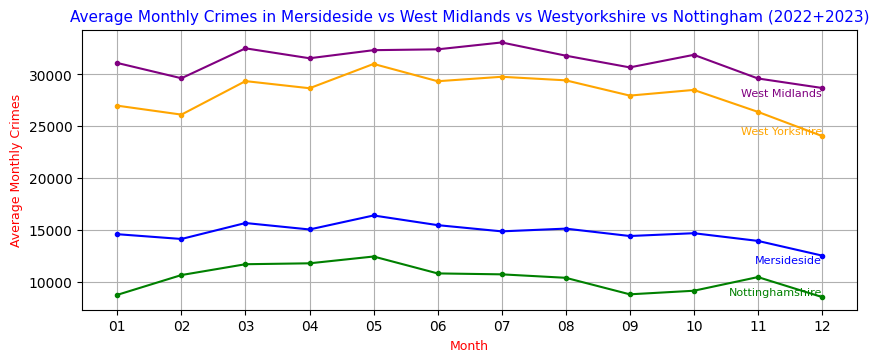

In [395]:
#Plot the average monthly visualisation of joined tables, set title, x,y labels, format font
#Label the line graphs each county
m = monthArray
ay = monthavgArray_Y
an = monthavgArray_N
am = monthavgArray_M
aw = monthavgArray_W
plt.figure (figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(m, ay, '.-', color = 'orange', label = 'West Yorkshire')
plt.plot(m, an, '.-', color = 'green', label = 'Nottinghamshire')
plt.plot(m, am, '.-', color = 'blue', label = 'Merseyside')
plt.plot(m, aw, '.-', color = 'purple', label = 'West Midlands')
plt.text(m[-1], ay[-1], 'West Yorkshire', color='orange', fontsize=8, verticalalignment='bottom', horizontalalignment='right')
plt.text(m[-1], an[-1], 'Nottinghamshire', color='green', fontsize=8, verticalalignment='bottom', horizontalalignment='right')
plt.text(m[-1], am[-1], 'Mersideside', color='blue', fontsize=8, verticalalignment='top', horizontalalignment='right')
plt.text(m[-1], aw[-1], 'West Midlands', color='purple', fontsize=8, verticalalignment='top', horizontalalignment='right')
plt.title('Average Monthly Crimes in Mersideside vs West Midlands vs Westyorkshire vs Nottingham (2022+2023)', color = 'blue', 
          fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.xlabel('Month', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Monthly Crimes', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.grid(True)
plt.show()

In [396]:
#Prepare variables for yearly visualisation without joining tables
#Convert dataframe into RDD
yearArray = sqlContext.sql("select Year from Merseyside_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearavgArray_M = sqlContext.sql("select Average from Merseyside_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Westmidlands_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearavgArray_W = sqlContext.sql("select Average from Westmidlands_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Westyorkshire_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearavgArray_Y = sqlContext.sql("select Average from Westyorkshire_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from Nottingham_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()
yearavgArray_N = sqlContext.sql("select Average from Nottingham_yearly_crime_tb")\
.rdd.map(lambda f:f[0]).collect()

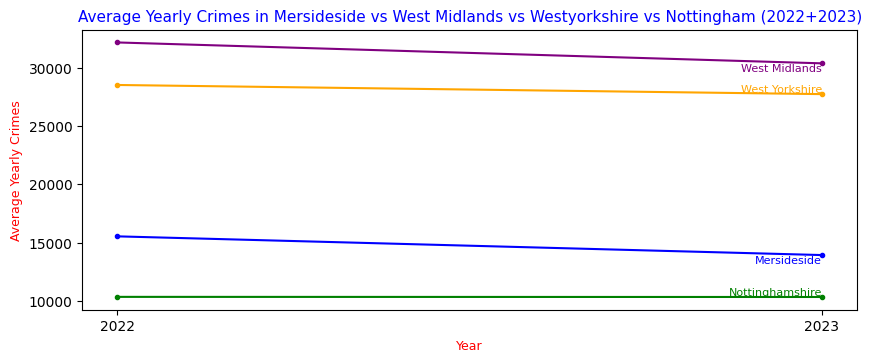

In [397]:
#Plot the average yearly visualisation, set title, x,y labels, format font
#Label the line graphs each county
y = yearArray
ya_y = yearavgArray_Y
ya_n = yearavgArray_N
ya_m = yearavgArray_M
ya_w = yearavgArray_W
plt.figure (figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(y, ya_y, '.-', color = 'orange', label = 'West Yorkshire')
plt.plot(y, ya_n, '.-', color = 'green', label = 'Nottinghamshire')
plt.plot(y, ya_m, '.-', color = 'blue', label = 'Merseyside')
plt.plot(y, ya_w, '.-', color = 'purple', label = 'West Midlands')
plt.text(y[-1], ya_y[-1], 'West Yorkshire', color='orange', fontsize=8, verticalalignment='bottom', horizontalalignment='right')
plt.text(y[-1], ya_n[-1], 'Nottinghamshire', color='green', fontsize=8, verticalalignment='bottom', horizontalalignment='right')
plt.text(y[-1], ya_m[-1], 'Mersideside', color='blue', fontsize=8, verticalalignment='top', horizontalalignment='right')
plt.text(y[-1], ya_w[-1], 'West Midlands', color='purple', fontsize=8, verticalalignment='top', horizontalalignment='right')
plt.title('Average Yearly Crimes in Mersideside vs West Midlands vs Westyorkshire vs Nottingham (2022+2023)', color = 'blue', 
          fontsize = 11, fontstyle = 'normal', fontname = 'calibri(head)')
plt.xlabel('Year', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.ylabel('Average Yearly Crimes', color = 'red', fontsize = 9, fontstyle = 'normal', fontname = 'calibri(body)')
plt.show()